In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import torchsummary
from torchvision import transforms
import time
from sklearn.metrics import classification_report

In [4]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()

In [5]:
data_path='/home/sumins/workspace/washout classification/min_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [6]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [7]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])


In [8]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__() #상속받은 class에 접근하기 위함

        self.layer1 = self.conv_module(4, 16) #흑백사진은 inp
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        
model=CustomConvNet()
torchsummary.summary(model.cuda(),input_size=(4,512,512),batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 16, 512, 512]             592
       BatchNorm2d-2          [4, 16, 512, 512]              32
         LeakyReLU-3          [4, 16, 512, 512]               0
         MaxPool2d-4          [4, 16, 256, 256]               0
            Conv2d-5          [4, 32, 256, 256]           4,640
       BatchNorm2d-6          [4, 32, 256, 256]              64
         LeakyReLU-7          [4, 32, 256, 256]               0
         MaxPool2d-8          [4, 32, 128, 128]               0
            Conv2d-9          [4, 64, 128, 128]          18,496
      BatchNorm2d-10          [4, 64, 128, 128]             128
        LeakyReLU-11          [4, 64, 128, 128]               0
        MaxPool2d-12            [4, 64, 64, 64]               0
           Conv2d-13           [4, 128, 64, 64]          73,856
      BatchNorm2d-14           [4, 128,

In [9]:
hyper_param_epoch=200
hyper_param_batch=8
hyper_param_learning_rate=0.0001

In [10]:
print(len(channel4))
print(len(channel4t))

1422
363


In [11]:
train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_train)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=CustomConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 1


In [13]:
def validation_loss(model):
    total_loss=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
 
        outputs =model(npys)
        loss = criterion(outputs, labels)

        total_loss+=loss.item()
    return total_loss/(i_batch+1)

In [48]:
loss_value=1
start=time.time()
custom_model.train()
train_loss_history=[]
valid_loss_history=[]
val_loss=0
for e in range(hyper_param_epoch):
        for i_batch, item in enumerate(train_loader):
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                #print(npys)
                # Forward pass
                outputs =custom_model(npys)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss=validation_loss(custom_model)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Valid_loss: {:.4f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(),val_loss))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': custom_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, '/home/sumins/workspace/washout classification/model_save/model4.pth')


Epoch [1/200],i_batch=178 ,Train_Loss: 0.6793,Valid_loss: 0.6684
Time: 151.14633464813232sec
Epoch [2/200],i_batch=178 ,Train_Loss: 0.6098,Valid_loss: 0.6430
Time: 141.67822909355164sec
Epoch [3/200],i_batch=178 ,Train_Loss: 0.6098,Valid_loss: 0.6389
Time: 136.2256076335907sec
Epoch [4/200],i_batch=178 ,Train_Loss: 0.5180,Valid_loss: 0.6340
Time: 154.28347182273865sec
Epoch [5/200],i_batch=178 ,Train_Loss: 0.5047,Valid_loss: 0.6405
Time: 137.62167191505432sec
Epoch [6/200],i_batch=178 ,Train_Loss: 0.5477,Valid_loss: 0.6471
Time: 136.0696828365326sec
Epoch [7/200],i_batch=178 ,Train_Loss: 0.4720,Valid_loss: 0.6230
Time: 146.24592900276184sec
Epoch [8/200],i_batch=178 ,Train_Loss: 0.5585,Valid_loss: 0.6275
Time: 139.71245956420898sec
Epoch [9/200],i_batch=178 ,Train_Loss: 0.4824,Valid_loss: 0.6291
Time: 143.1551125049591sec
Epoch [10/200],i_batch=178 ,Train_Loss: 0.5131,Valid_loss: 0.6437
Time: 145.8060278892517sec
Epoch [11/200],i_batch=178 ,Train_Loss: 0.4639,Valid_loss: 0.6386
Time: 1

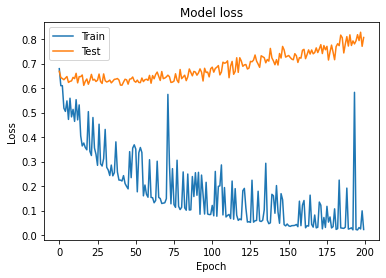

In [49]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

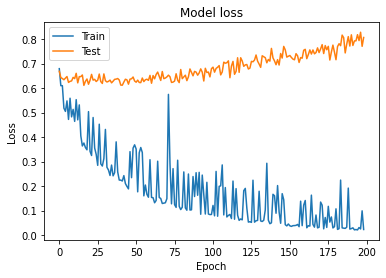

In [89]:
v=valid_loss_history[:]

t=train_loss_history[:]
del v[193]

del t[193]
plt.plot(t)
plt.plot(v)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [50]:
import csv


with open("v_loss_min.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)
with open("t_loss_min.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)

In [104]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/model4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch)
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
       
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

16
tensor(0.3756, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 363 test images: 73.82920110192838 %


In [105]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.59      0.25      0.35       103
           1       0.76      0.93      0.84       260

    accuracy                           0.74       363
   macro avg       0.67      0.59      0.59       363
weighted avg       0.71      0.74      0.70       363



: 

In [16]:
true_label=[]
pred_label=[]
zero_zero=[]
zero_one=[]
one_zero=[]
one_one=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/model4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch)
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        labels=labels.tolist()
        predicted=predicted.tolist()
        npys=npys.tolist()
        for i in range(hyper_param_batch):
            if labels[i]==0 and predicted[i]==0:
                zero_zero.append(npys[i])
            elif  labels[i]==0 and predicted[i]==1:
                zero_one.append(npys[i])
            elif labels[i]==1 and predicted[i]==0:
                one_zero.append(npys[i])
            elif  labels[i]==1 and predicted[i]==1:
                one_one.append(npys[i])
        print("done")
    
       
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

16
tensor(0.3756, device='cuda:0', requires_grad=True)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


IndexError: list index out of range

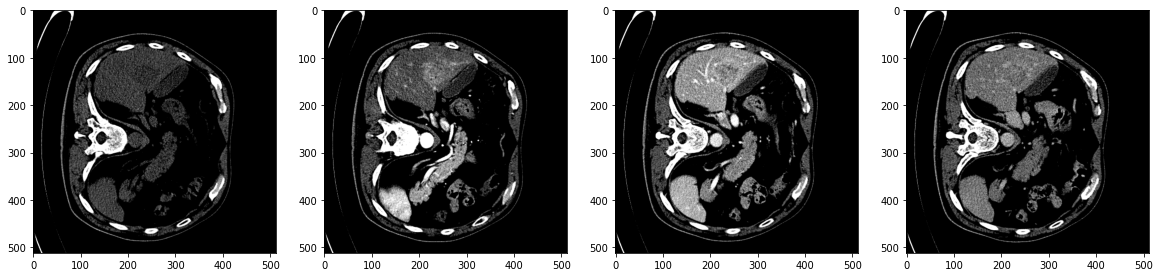

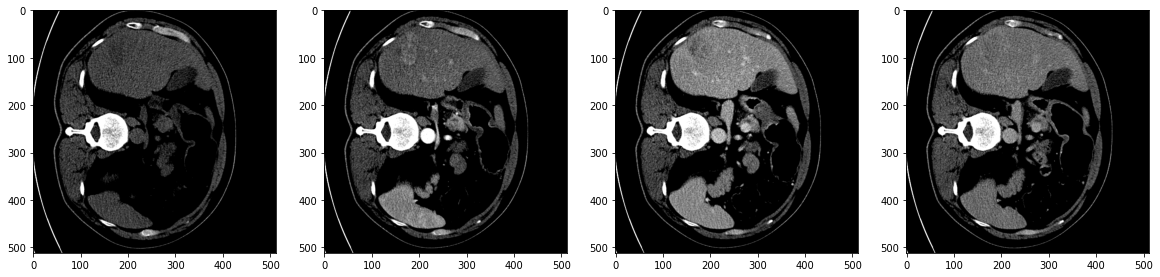

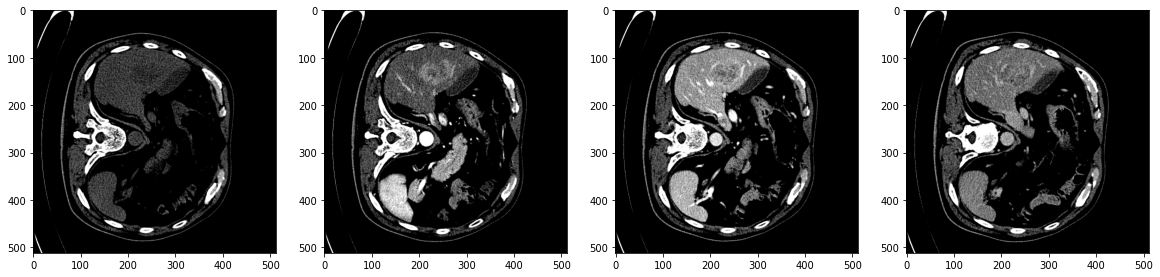

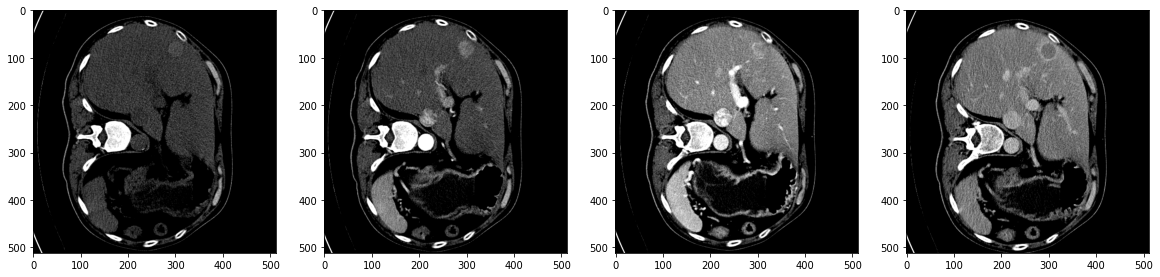

In [88]:
one_one_n= np.array(one_one)

for k in [40,56,66,69]:
    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    my=one_one_n[k]
    for i in [1,0,3,2]:
        
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.reshape(np.fliplr(my[i,:,:]),(512,512)),cmap='gray')
    plt.show()


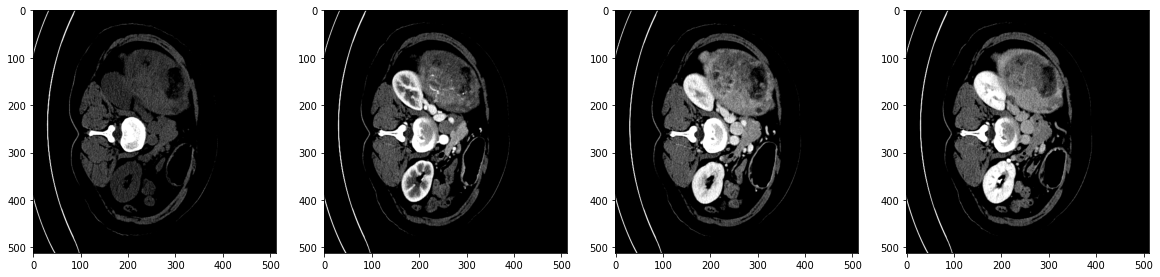

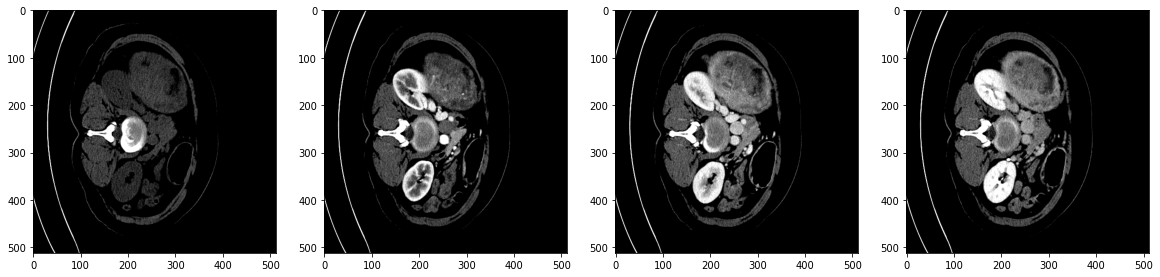

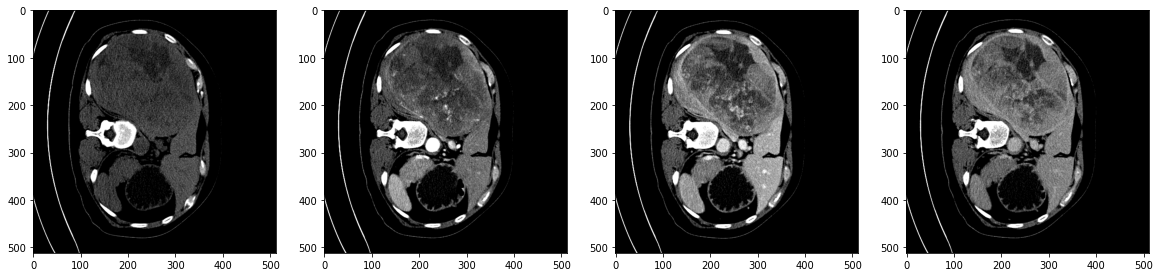

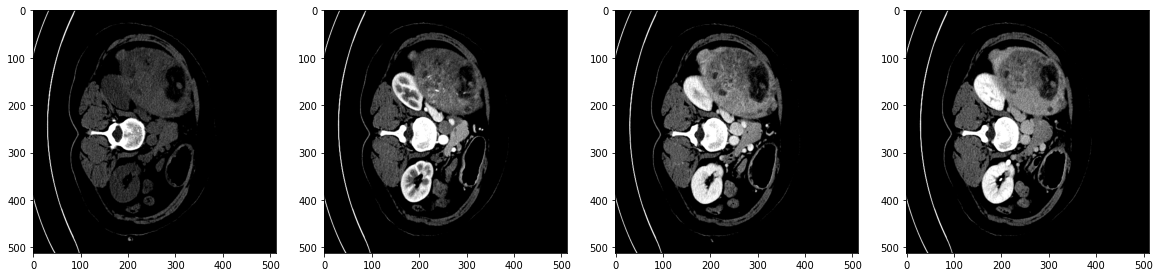

In [97]:
zero_zero_n= np.array(zero_zero)

for k in [0,7,9,10]:
    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    my=zero_zero_n[k]
    for i in [1,0,3,2]:
        
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.reshape(np.fliplr(my[i,:,:]),(512,512)),cmap='gray')
    plt.show()


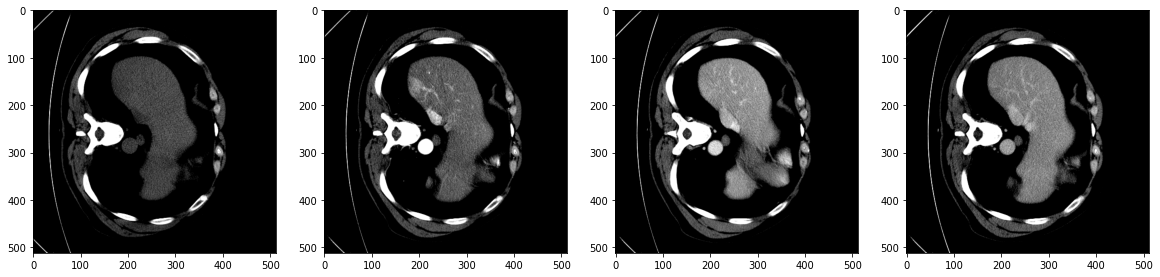

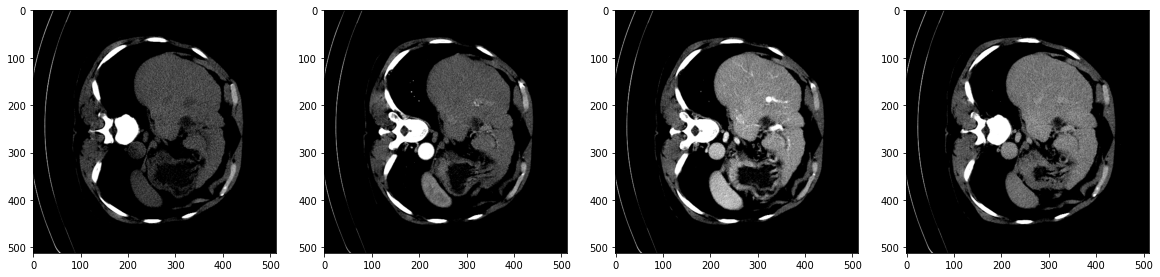

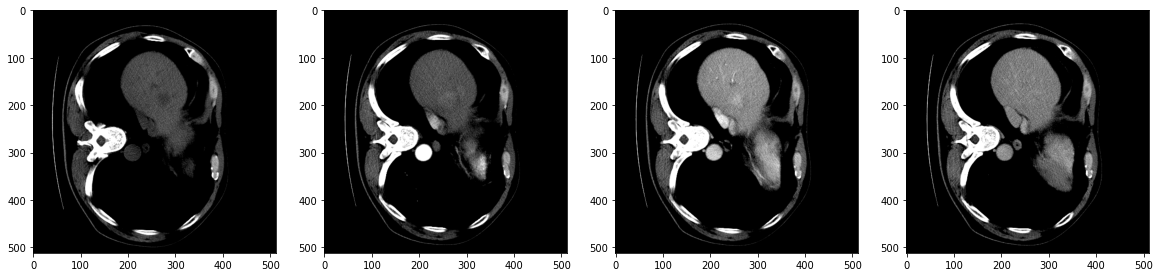

In [101]:
zero_one_n= np.array(zero_one)

for k in [5,17,18]:
    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    my=zero_one_n[k]
    for i in [1,0,3,2]:
        
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.reshape(np.fliplr(my[i,:,:]),(512,512)),cmap='gray')
    plt.show()


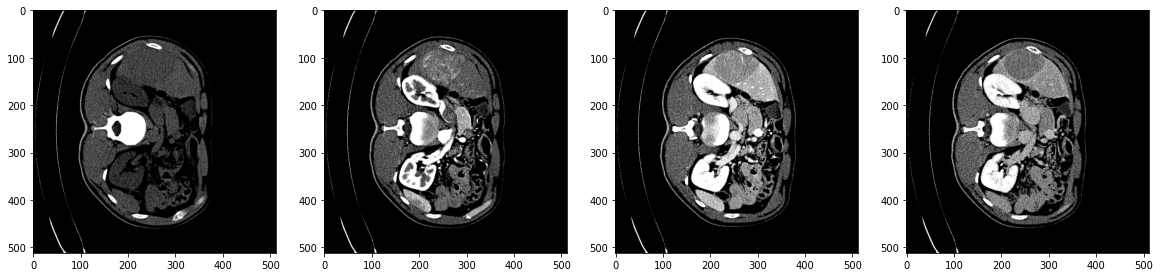

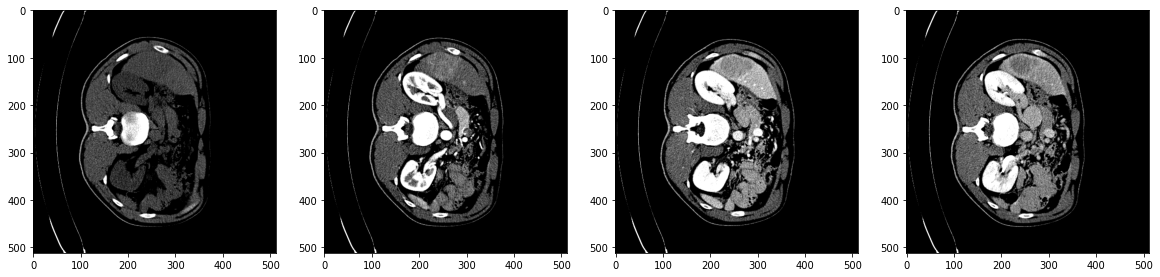

In [17]:
one_zero_n= np.array(one_zero)

for k in [1,6]:
    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    my=one_zero_n[k]
    for i in [1,0,3,2]:
        
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.reshape(np.fliplr(my[i,:,:]),(512,512)),cmap='gray')
    plt.show()


In [56]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/model4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
custom_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in train_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
       
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

tensor(0.3756, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 1422 test images: 95.85091420534458 %


In [57]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       343
           1       0.98      0.97      0.97      1079

    accuracy                           0.96      1422
   macro avg       0.94      0.95      0.94      1422
weighted avg       0.96      0.96      0.96      1422

